# Lokaverkefni - Deloitte

In [2]:
!pip install pydicom
!pip install torch
!pip install albumentations
from skimage import color, io, measure, img_as_ubyte, draw
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
from os import listdir
from os.path import isfile, join
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt
from skimage.filters import median
from skimage.filters import gaussian

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/DTU/clean_data/'

Load the data

In [1]:
test_ids = ['0_a.jpg','1_a.jpg','2_a.jpg','3_a.jpg','5_a.jpg','6_a.jpg','10_a.jpg','11_a.jpg','12_a.jpg','19_a.jpg','20_a.jpg','21_a.jpg','22_a.jpg','24_a.jpg','26_a.jpg','28_a.jpg','29_a.jpg','32_a.jpg','33_a.jpg','35_a.jpg','36_a.jpg','39_a.jpg','40_a.jpg','43_a.jpg','45_a.jpg','46_a.jpg','47_a.jpg','50_a.jpg','51_a.jpg','52_a.jpg']
test_ids = [s.replace('jpg', 'npy') for s in test_ids] # use clean data

train_ids = ['71_a.jpg','412.jpg','283_a.jpg','68_a.jpg','95_a.jpg','201.jpg','363_a.jpg','361.jpg','62.jpg','74.jpg','57_a.jpg','281_a.jpg','409_a.jpg','199_a.jpg',
 '121_a.jpg','73_a.jpg','59.jpg','341_a.jpg','158.jpg','125_a.jpg','224_a.jpg','381_a.jpg','285_a.jpg','64.jpg','8.jpg','66.jpg','557_a.jpg','211.jpg','75_a.jpg',
 '801_a.jpg','73.jpg','9.jpg','471.jpg','104_a.jpg','141_a.jpg','120_a.jpg','72_a.jpg','379_a.jpg','795_a.jpg','158_a.jpg','114.jpg','29.jpg','15.jpg','116.jpg',
'499.jpg','54_a.jpg','773_a.jpg','301.jpg','103.jpg','94_a.jpg','16.jpg','12.jpg','102_a.jpg','259.jpg','417_a.jpg','13.jpg','74_a.jpg','39.jpg','124_a.jpg',
 '535_a.jpg', '272.jpg','428_a.jpg','399_a.jpg','475.jpg','313.jpg','38.jpg','108.jpg','120.jpg','699_a.jpg','493.jpg','664_a.jpg','518.jpg','334_a.jpg','121.jpg',
 '34.jpg','87_a.jpg','78_a.jpg','241.jpg','312_a.jpg','308.jpg','37.jpg','33.jpg','65_a.jpg','137_a.jpg','536.jpg','353_a.jpg','331.jpg','26.jpg','32.jpg',
'156_a.jpg', '113_a.jpg','455.jpg','290.jpg','83_a.jpg','351_a.jpg','130.jpg','519_a.jpg','31.jpg','42.jpg','180.jpg','582_a.jpg','153_a.jpg','209.jpg','79_a.jpg','606_a.jpg','60_a.jpg','5.jpg',
 '57.jpg','7.jpg','41.jpg','69.jpg','82.jpg','700_a.jpg','62_a.jpg','249_a.jpg',
 '816_a.jpg','86_a.jpg','237.jpg','724_a.jpg','182.jpg','114_a.jpg','54.jpg','6.jpg', '192.jpg', '44.jpg', '93.jpg', '798_a.jpg', '66_a.jpg', '45.jpg', '193.jpg', '855_a.jpg',
 '84.jpg','64_a.jpg','224.jpg','99_a.jpg','706_a.jpg','112_a.jpg','85.jpg','147.jpg']

train_ids = [s.replace('jpg', 'npy') for s in train_ids] # use clean data

In [5]:
from torch.utils.data import Dataset
import torch
import os

class ImageDataset(Dataset): # call AugmentingDataset
    def __init__(self, path, img_ids, transform):
      self.path = path
      self.img_ids = img_ids
      self.transform = transform

    def __getitem__(self, i):
      img_id = self.img_ids[i]
      data = np.load(os.path.join(self.path, img_id))
  
      img = data[0:3]
      mask = data[-1]

      transformed = self.transform(image=img, mask=mask)

      img = transformed['image'] # .transpose(1,2,0)
      mask = transformed['mask']

      return {'imgs': torch.Tensor(img), 'masks': torch.Tensor(mask)}
    
    def __len__(self):
      return len(self.img_ids)


In [6]:
import albumentations as A

transform = A.Compose([A.HorizontalFlip(p=1),
                       #A.RandomCrop(width=256, height=256),
                       A.RandomBrightnessContrast(p=0.2)]) #BÆTA VID HER

train_dataset = ImageDataset(path, train_ids, transform)
#test_dataset = ImageDataset(path, test_ids, transform)

batch_size = len(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
#test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for batch in train_loader:
    b = batch
    break


KeyError: ignored

In [ ]:
b['imgs'].shape[0]

In [ ]:
b['masks'].shape

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)

           

    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches

In [ ]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
n_channels = 3
n_classes=len(np.unique(b['masks'])) #Number of classes for segmentation
learning_rate = 1e-5
epochs = 5
n_train = b['imgs'].shape[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# (Initialize logging)
experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
experiment.config.update(dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                                  val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale,
                                  amp=amp))

In [ ]:
from torch import optim
from tqdm import tqdm

net = UNet(n_channels, n_classes)


optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()
global_step = 0

In [ ]:
#Begin training
for epoch in range(1, epochs+1):
  net.train()
  epoch_loss = 0
  with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
    for batch in train_loader:
     images = b['imgs']
     true_masks = b['masks']

    assert images.shape[1] == net.n_channels, \
    f'Network has been defined with {net.n_channels} input channels, ' \
    f'but loaded images have {images.shape[1]} channels. Please check that ' \
    'the images are loaded correctly.'

    images = images.to(device=device, dtype=torch.float32)
    true_masks = true_masks.to(device=device, dtype=torch.long)

    with torch.cuda.amp.autocast():
      masks_pred = net(images)
      loss = criterion(masks_pred, true_masks) \
      + dice_loss(F.softmax(masks_pred, dim=1).float(),
                                   F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                                   multiclass=True)

      optimizer.zero_grad(set_to_none=True)
      grad_scaler.scale(loss).backward()
      grad_scaler.step(optimizer)
      grad_scaler.update()

      pbar.update(images.shape[0])
      global_step += 1
      epoch_loss += loss.item()
      experiment.log({
        'train loss': loss.item(),
        'step': global_step,
        'epoch': epoch
              })
      pbar.set_postfix(**{'loss (batch)': loss.item()})

      # Evaluation round
      division_step = (n_train // (10 * batch_size))
      if division_step > 0:
        if global_step % division_step == 0:
          histograms = {}
          for tag, value in net.named_parameters():
            tag = tag.replace('/', '.')
            if not torch.isinf(value).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                if not torch.isinf(value.grad).any():
                  histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                  val_score = evaluate(net, val_loader, device)
                  scheduler.step(val_score)
                  logging.info('Validation Dice score: {}'.format(val_score))
                  experiment.log({
                        'learning rate': optimizer.param_groups[0]['lr'],
                        'validation Dice': val_score,
                        'images': wandb.Image(images[0].cpu()),
                        'masks': {
                            'true': wandb.Image(true_masks[0].float().cpu()),
                            'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                        },
                        'step': global_step,
                        'epoch': epoch,
                         **histograms
                    })

if save_checkpoint:
    Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
    torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
    logging.info(f'Checkpoint {epoch} saved!')

In [ ]:
|X_train = np.zeros((len(train_ids),256,256,3))
Y_train = np.zeros((len(train_ids),256,256))

i=0
for image in train_ids:
    org_img = np.load(path+image)
    #input image
    input_img = org_img[0:256,256:512] 
    img = np.load(path+image)
    input_img = img[0:3].transpose(1,2,0)
    target_img = img[-1]
    #im_gray = color.rgb2gray(input_img)
    X_train[i] = input_img
    Y_train[i] = target_img
    
    i+=1


X_test = np.zeros((len(test_ids),256,256,3))
Y_test = np.zeros((len(test_ids),256,256))

i=0
for image in test_ids:
    org_img = np.load(path+image)
    #input image
    input_img = org_img[0:256,256:512] 
    img = np.load(path+image)
    input_img = img[0:3].transpose(1,2,0)
    target_img = img[-1]
    #im_gray = color.rgb2gray(input_img)
    X_test[i] = input_img
    Y_test[i] = target_img
    
    i+=1

SyntaxError: ignored

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


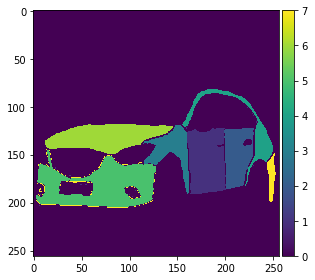

In [ ]:
io.imshow(Y_train[0])
io.show()

DeepLabv3Plus model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [ ]:
def DeepLabV3Plus(shape, n_classes):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(n_classes, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
X_train = X_train.reshape(139,256,256,3)
Y_train = Y_train.reshape(139,256,256,1)

X_test = X_test.reshape(30,256,256,3)
Y_test = Y_test.reshape(30,256,256,1)

In [ ]:
X_train.shape

(139, 256, 256, 3)

In [ ]:
Y_test.shape

(30, 256, 256, 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w, c = Y_train.shape
train_masks_reshaped = Y_train.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w, c)
Y_train = np.expand_dims(train_masks_encoded_original_shape, axis=3)


n, h, w, c = Y_test.shape
test_masks_reshaped = Y_test.reshape(-1,1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w, c)

Y_test = np.expand_dims(test_masks_encoded_original_shape, axis=3)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
n_classes=len(np.unique(Y_train)) #Number of classes for segmentation


from keras.utils import to_categorical


train_masks_cat = to_categorical(Y_train,n_classes)
y_train_cat = train_masks_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))


test_masks_cat = to_categorical(Y_test,n_classes)
y_test_cat = test_masks_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(train_masks_reshaped_encoded),
                                                 y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

class_weight_dict = {i:class_weights[i]/max(class_weights) for i in range(9)}

Class weights are...: [0.13968686 3.07609374 6.03939945 5.72875059 5.22708293 2.53322966
 2.97757512 6.90498421 9.15963468]


In [ ]:
from keras import backend as K


def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [ ]:
def get_model():
  input_shape = (256, 256, 3)
  n_classes=len(np.unique(Y_train)) #Number of classes for segmentation
  return  DeepLabV3Plus(input_shape, n_classes)

model = get_model()
model.compile(optimizer='adam', loss=[categorical_focal_loss(alpha=[list(class_weights)], gamma=2)], metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=15, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weight_dict,
                    shuffle=False)

model.save('test.hdf5')

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
model.evaluate(X_test, y_test_cat)

1/1 [==============================] - 13s 13s/step - loss: 81.4074 - accuracy: 0.5313


[81.40738677978516, 0.5312535762786865]

In [ ]:
#Evaluate the model
# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


val_acc = history.history['val_acc']
acc = history.history['acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

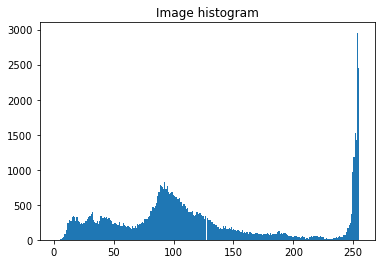

In [ ]:
plt.hist(im_byte.ravel(), bins=256)
plt.title('Image histogram')
io.show()

In [ ]:
#def threshold_image(img_in, thres):
#    """
#    Apply a threshold in an image and return the resulting image
#    :param img_in: Input image
#    :param thres: The treshold value in the range [0, 255]
#    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
#    """
#    img_out = img_in.copy()
#
#    img_out[img_out > thres] = 255
#    img_out[img_out <= thres] = 0
#    
#    return img_as_ubyte(img_out)   

In [ ]:
#from skimage.filters import threshold_otsu
#thresh = threshold_otsu(im_byte)
#thresh
#
#thres_img = threshold_image(im_byte, thresh)
#io.imshow(thres_img, vmin=np.min(thres_img), vmax=np.max(thres_img))
#plt.title('Threshold image')
#io.show()

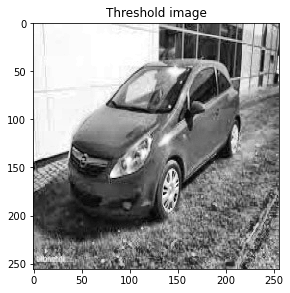

In [ ]:
import cv2
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
cl_img = clahe.apply(im_byte)
io.imshow(cl_img, vmin=np.min(cl_img), vmax=np.max(cl_img))
plt.title('Threshold image')
io.show()

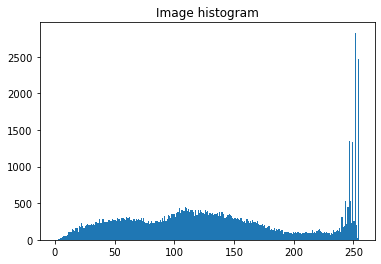

In [ ]:
# Here we can see that curve is smoother than before CLACHE
plt.hist(cl_img.ravel(), bins=256)
plt.title('Image histogram')
io.show()

In [ ]:
# From https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

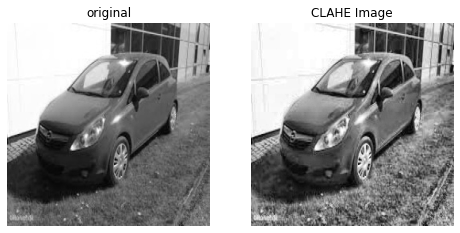

In [ ]:
plot_comparison(im_byte,cl_img,'CLAHE Image')

In [ ]:
# Apply CLAHE to the whole data

path = 'C:/Users/Rebekka/Desktop/DTU/Deep Learning/Lokaverkefni/carseg_data/carseg_raw_data/train/photo'

X_train = np.zeros((len(train_ids),256,256))
Y_train = np.zeros((len(train_ids),256,256))
i=0
for image in train_ids:
    
    org_img = io.imread('carseg_data/carseg_raw_data/train/photo/'+image)
    #input image
    input_img = org_img[0:256,256:512]
    im_gray_input = color.rgb2gray(input_img)
    im_byte_input = img_as_ubyte(im_gray_input) #forcing the pixel type back into unsigned bytes
    cl_img = clahe.apply(im_byte_input)
    X_train[i]=cl_img
    
    #target image
    target_img = org_img[0:256,0:256]
    im_gray_target = color.rgb2gray(target_img)
    im_byte_target = img_as_ubyte(im_gray_target) #forcing the pixel type back into unsigned bytes
    Y_train[i]=im_byte_target
    
    i+=1
    

X_test = np.zeros((len(test_ids),256,256))
#Y_test = np.zeros((len(test_ids),256,256))
i=0
for image in test_ids:
    
    org_img = io.imread('carseg_data/carseg_raw_data/train/photo/'+image)
    #input image
    input_img = org_img[0:256,256:512]
    im_gray_input = color.rgb2gray(input_img)
    im_byte_input = img_as_ubyte(im_gray_input) #forcing the pixel type back into unsigned bytes
    cl_img = clahe.apply(im_byte_input)
    X_test[i]=cl_img
    
    # Þurfum ekki þetta útaf við erum að fara að gera þetta
    #target image 
    #target_img = org_img[0:256,0:256]
    #im_gray_target = color.rgb2gray(target_img)
    #im_byte_target = img_as_ubyte(im_gray_target) #forcing the pixel type back into unsigned bytes
    #Y_test[i]=im_byte_target
    
    i+=1

    
    

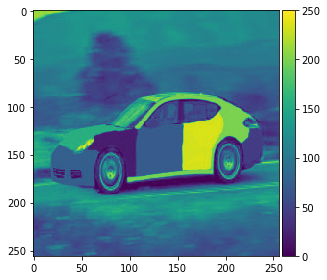

In [ ]:
io.imshow(X_test[0])
io.show()


In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
#from keras.optimizers import Adam
import keras
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard
from keras import backend as keras
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

In [ ]:
import tensorflow as tf

In [ ]:
np.random.seed = 42

In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    #inputs = Input(input_size)
    inputs = Lambda(lambda x: x / 255)(Input(input_size))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary() #prints out summary of model

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
model = unet()
#Model checkpoint
#tf.keras.callbacks.ModelCheckpoint(filepath - hér save-a ég þetta í current file-num með nafninu model_for_carparts.h5)
model_checkpoint = ModelCheckpoint('model_for_carparts.h5', monitor='loss',verbose=1, save_best_only=True)
model_callbacks = [EarlyStopping(patience = 2, monitor ='val_loss'),
                  TensorBoard(log_dir = 'logs')]

results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 25, callbacks = model_callbacks)



Epoch 1/25
8/8 [==============================] - 707s 81s/step - loss: 237.4556 - accuracy: 0.0029 - val_loss: -0.1576 - val_accuracy: 0.0040
Epoch 2/25
8/8 [==============================] - 526s 66s/step - loss: -0.5619 - accuracy: 0.0029 - val_loss: -1.0758 - val_accuracy: 0.0040
Epoch 3/25
8/8 [==============================] - 636s 80s/step - loss: -1.5059 - accuracy: 0.0029 - val_loss: -2.0036 - val_accuracy: 0.0040
Epoch 4/25
8/8 [==============================] - 580s 71s/step - loss: -2.4514 - accuracy: 0.0029 - val_loss: -2.9335 - val_accuracy: 0.0040
Epoch 5/25
8/8 [==============================] - 518s 62s/step - loss: -3.3834 - accuracy: 0.0029 - val_loss: -3.8697 - val_accuracy: 0.0040
Epoch 6/25
8/8 [==============================] - 480s 60s/step - loss: -4.3327 - accuracy: 0.0029 - val_loss: -4.7987 - val_accuracy: 0.0040
Epoch 7/25
8/8 [==============================] - 478s 60s/step - loss: -5.2853 - accuracy: 0.0029 - val_loss: -5.7198 - val_accuracy: 0.0040
Epoch

In [ ]:
import random

In [ ]:
idx = random.randint(0,len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)])
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):])
preds_test = model.predict(X_test)

In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

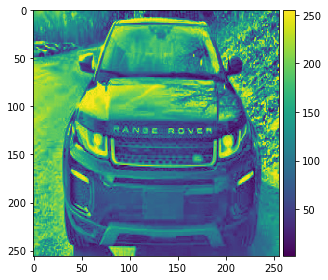

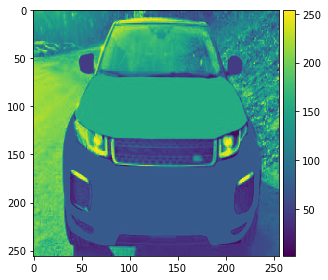

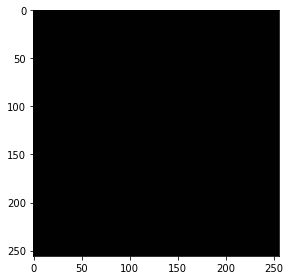

In [ ]:
ix = random.randint(0,len(preds_train_t))
io.imshow(X_train[ix])
io.show()
io.imshow(np.squeeze(Y_train[ix]))
io.show()
io.imshow(np.squeeze(preds_train_t[ix]))
io.show()